In [1]:
#データの取得と成形

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv("s&p_tweets.csv")
data.head()

,date,price,text
0,2020-05-01,2830.71,RT @StevenTDennis: Trump gets bump in latest G...
1,2020-05-01,2830.71,"The Governor of Michigan should give a little,..."
2,2020-05-01,2830.71,"Cryin Chuck Schumer, compared to what other Se..."
3,2020-05-01,2830.71,Cryin’ Chuck Schumer was on a late night show ...
4,2020-05-01,2830.71,RT @TeamTrump: President @realDonaldTrump: “We...


In [4]:
data.shape

(12226, 3)

In [5]:
#https://yottagin.com/?p=4360

import nltk

tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
for tweet in data["text"][:1]:
    print (tweet_tokenizer.tokenize(tweet))

['rt', ':', 'trump', 'gets', 'bump', 'in', 'latest', 'gallup', 'poll', ':', '49', '%', 'approval', '(', '+', '6', ',', 'tied', 'for', 'his', 'best', ')', '47', '%', 'disapproval', '(', '-', '7', ')']


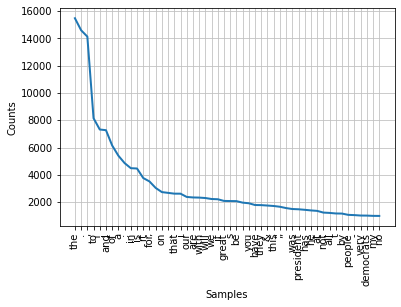

In [6]:
words = []
for tweet in data["text"]:
    words += tweet_tokenizer.tokenize(tweet)

fdist = nltk.FreqDist(words)
fdist.plot(50)

In [7]:
df_fdist = pd.DataFrame(fdist.most_common(10), columns=['Word', 'Frequency'])
#df_fdist

In [8]:
import re
#RTから始まる部分を削除
tweet = re.sub(r'^RT[\s]+', '', tweet)
#リンクを削除
tweet = re.sub(r'^RT[\s]+', '', tweet)
#ハッシュダグを削除
tweet = re.sub(r'#', '', tweet)
#Punctionを除去
import string
punctuations = string.punctuation
punctuations
#互換への変換
stemmer = nltk.stem.PorterStemmer()

In [9]:
import nltk
#nltk.download('stopwords')

In [10]:
import re
import string

stemmer = nltk.stem.PorterStemmer()
punctuations = string.punctuation
all_tweets_clean = []

#Tweet毎にリスト形式で保存するための加工
result=[]

for tweet in data["text"]:
    # RTから始まる部分を取り除く。
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # リンクを取り除く。
    tweet = re.sub(r'(http|https):\/\/.*[\r\n]*', '', tweet)
    # ハッシュタグを取り除く。
    tweet = re.sub(r'#', '', tweet)
    # 句読点の削除
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) 
    # 単語に分解する。
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    result.append(tweet_tokens)
    
#    tweets_clean = []
#   for word in tweet_tokens:
#        if (word not in stopwords and # stopwordsを除去する。
#               word not in punctuations): # punctuationを除去する。
#            #stem_word = stemmer.stem(word) # 単語を語幹に変形する。
#            tweets_clean.append(word)
#            all_tweets_clean += tweets_clean
            
#fdist_all_tweets_clean = nltk.FreqDist(all_tweets_clean)
#fdist_all_tweets_clean.plot(50)

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
stop_words = ["→", "←", "?", "」", "「","(",")","!",".",",","&","…","%",":",";","“"]
stopwords += stop_words

#print(stopwords)

result_2=[]
result_3=[]
for i in range(len(result)):
    for word in result[i]:
        if word not in stopwords:
            result_2.append(word)
    result_3.append(result_2)
    result_2=[]

In [12]:
#Word2Vec

from gensim.models import word2vec

unable to import 'smart_open.gcs', disabling that module


In [13]:
# 対象データをLinseSentence(one sentence = one lineとして扱う)で読み込む

sentences = result_3
sentences[0]

['steventdennis',
 'trump',
 'gets',
 'bump',
 'latest',
 'gallup',
 'poll',
 '49',
 'approval',
 '6',
 'tied',
 'best',
 '47',
 'disapproval',
 '7']

In [ ]:
# skip-gramモデルの学習
skipgram_model = word2vec.Word2Vec(sentences,
                                   sg=1,
                                   size=250,
                                   min_count=10,
                                   window=15, seed=1234)

In [14]:
# 作成したモデルの保存
#skipgram_model.save("skipgram_w2v.model")
# saveしたモデルを読み込む時は
skipgram_model = word2vec.Word2Vec.load("./skipgram_w2v.model")

In [15]:
# coronavirusと似たキーワードを見つけていきます。
# ここで記載しているscoreは、単語同士のコサイン類似度です。
pd.DataFrame(skipgram_model.wv.most_similar(
    positive=["coronavirus"]), columns=["keyword", "score"])

,keyword,score
0,response,0.844936
1,covid,0.833694
2,spread,0.828075
3,19,0.823361
4,task,0.814213
5,outbreak,0.798263
6,cdcgov,0.789784
7,providing,0.779386
8,distancing,0.770392
9,executive,0.769038


In [16]:
"""
1. 抽出された各単語を、作成したword2Vecによってベクトル化
2. 変換された各単語ベクトルの平均をとり、その結果得られたベクトルを記事のベクトルとする
上記2ステップを実行する関数を作成
"""

num_features = 250


def avg_document_vector(data, num_features):
    document_vec = np.zeros((len(data), num_features))
    for i, doc_word_list in enumerate(data):
        feature_vec = np.zeros((num_features,), dtype="float32")
        for word in doc_word_list:
            try:
                feature_vec = np.add(
                    feature_vec, skipgram_model.wv.__getitem__(word))
            except:
                pass

        feature_vec = np.divide(feature_vec, len(doc_word_list))
        document_vec[i] = feature_vec
    return document_vec

In [17]:
X = avg_document_vector(data=sentences, num_features=250)
X.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(12226, 250)

In [18]:
# outer join
data2 = pd.DataFrame(X)
df_tweets_word2vec =  pd.concat([data, data2], axis=1)
df_tweets_word2vec.head()

,date,price,text,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
0,2020-05-01,2830.71,RT @StevenTDennis: Trump gets bump in latest G...,0.017511,0.033036,-0.055609,-0.086756,0.038204,0.007787,0.009487,...,-0.025825,-0.143078,0.074192,-0.021282,-0.023262,-0.015457,0.059069,0.099523,0.037090,-0.158329
1,2020-05-01,2830.71,"The Governor of Michigan should give a little,...",0.116268,0.206312,-0.061226,-0.027443,-0.024336,0.020309,0.140659,...,-0.023505,-0.236269,0.122842,0.018296,-0.007191,0.086792,0.035547,0.105070,0.020868,-0.117669
2,2020-05-01,2830.71,"Cryin Chuck Schumer, compared to what other Se...",0.107201,0.149604,-0.060804,-0.017472,-0.022624,-0.010882,0.114679,...,-0.008816,-0.226043,0.126307,0.028040,0.019861,0.073369,0.061576,0.095116,0.047083,-0.111482
3,2020-05-01,2830.71,Cryin’ Chuck Schumer was on a late night show ...,0.080933,0.126144,-0.048920,-0.041991,-0.030629,0.019780,0.140582,...,-0.041110,-0.247888,0.124528,0.045370,0.009205,0.053368,0.073823,0.079290,0.070780,-0.130648
4,2020-05-01,2830.71,RT @TeamTrump: President @realDonaldTrump: “We...,0.076822,0.078205,-0.045310,-0.066868,0.015297,-0.005735,0.037144,...,-0.062958,-0.211431,0.120815,-0.014881,0.009230,0.052308,0.062994,0.212341,0.024647,-0.208380


In [19]:
df_tweets_word2vec.to_csv("price_tweets_vector.csv", index=False)

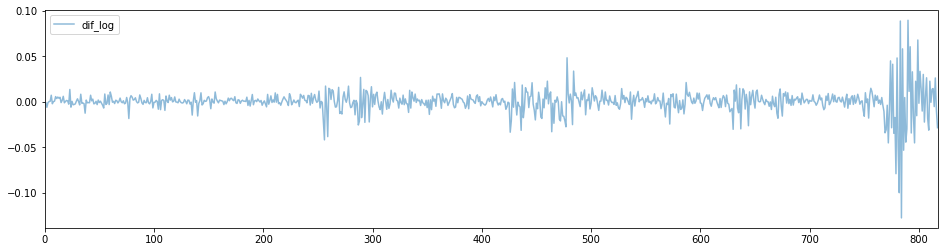

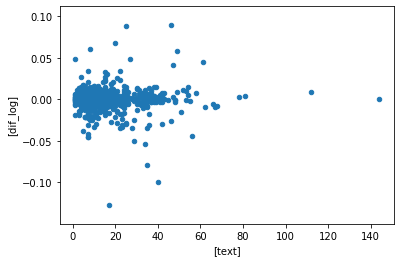

In [94]:
#ツイートのベクトルを1日毎に平均にする（1日10ツイートだった場合ベクトルと足し合わせ10で割る）
# groupby #https://qiita.com/propella/items/a9a32b878c77222630ae
df = df_tweets_word2vec.groupby(["date"]).mean()


# targetのcolである変化率（"price"の差分対数行列）をdateをKeyに内部結合する
df_sp = pd.read_csv("sp500-10-year-daily-chart.csv")

# 時系列データの差分を求める

# " value"の行を対数化
# https://www.sejuku.net/blog/70027
df_sp["log"] = np.log(df_sp[" value"])

# "log"の1日前との差を取って、差分対数の列を作成
# https://note.nkmk.me/python-pandas-diff-pct-change/
df_sp["dif_log"] = df_sp["log"].diff()

#内部結合
df2=pd.merge(df_sp, df, how="inner" ,on="date")
df2 = df2.drop(" value", axis=1)

# groupbyを使って1日のツイート数も特徴量に加える
# https://deepage.net/features/pandas-count.html
df3 = df_tweets_word2vec[["date","text"]]
df3 = df3.groupby(["date"]).count()

#内部結合
df4 = pd.merge( df3, df2, how="inner" ,on="date")

#日付データの形を変える
df4["date"] = pd.to_datetime(df4['date']).astype('int64')

#変化率のグラフ
df4.plot( y=["dif_log"], figsize=(16,4), alpha=0.5)

#ツイート数と変化率の関係
df4.plot.scatter(x=["text"], y=["dif_log"])

In [95]:
df4.head()

,date,text,log,dif_log,price,0,1,2,3,4,...,240,241,242,243,244,245,246,247,248,249
0,1485388800000000000,4,7.739220,-0.000736,2296.68,0.028186,0.063896,-0.054952,-0.081198,-0.005036,...,-0.015950,-0.256750,0.095328,0.027891,-0.052631,0.057231,0.028564,0.067227,-0.011364,-0.158354
1,1485475200000000000,7,7.738353,-0.000867,2294.69,0.049721,0.176991,-0.085925,-0.025510,-0.026521,...,-0.013792,-0.229306,0.128353,-0.002184,-0.067476,0.090140,0.014357,0.133015,0.025477,-0.158135
2,1485734400000000000,7,7.732325,-0.006028,2280.90,0.072995,0.164643,-0.069141,-0.030508,-0.007188,...,-0.009502,-0.219064,0.108246,0.005359,-0.015952,0.063800,0.051648,0.115916,0.024918,-0.139839
3,1485820800000000000,3,7.731435,-0.000890,2278.87,0.109382,0.112762,-0.045016,-0.081742,0.013047,...,0.000737,-0.269361,0.106410,0.051216,0.013596,0.054842,0.047909,0.053978,0.037297,-0.127028
4,1485907200000000000,4,7.731733,0.000298,2279.55,0.060450,0.150733,-0.081919,-0.046430,-0.042003,...,-0.017719,-0.264643,0.142889,-0.007400,-0.034531,0.090331,0.033544,0.167153,-0.010577,-0.189657


In [108]:
#特徴量とターゲットを決める
from sklearn.model_selection import train_test_split

target_col = 'dif_log'
exclude_cols = ['log', 'price', 'dif_log',"date"]
feature_cols = []
for col in df4.columns:
    if col not in exclude_cols:
        feature_cols.append(col)
        
X = np.array(df4[feature_cols])
y = np.array(df4[target_col])

In [109]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=1234)

# 参考：分割後のデータ数を確認
print('X_train Features Shape: ', X_train.shape)
print('y_train Target Shape: ', y_train.shape)
print('X_val Features Shape: ', X_val.shape)
print('y_val Target Shape: ', y_val.shape)

X_train Features Shape:  (572, 251)
y_train Target Shape:  (572,)
X_val Features Shape:  (246, 251)
y_val Target Shape:  (246,)


In [110]:
#分析用のライブラリ

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression  # 線形回帰モデルのライブラリ
from sklearn.metrics import mean_squared_error  # MSEのライブラリ
from sklearn.ensemble import RandomForestRegressor

In [111]:
# Accuracy, Precision/Recall/F-score/Support, Confusion Matrix を表示
def show_evaluation_metrics(y_true, y_pred):
    print("Accuracy:")
    print(accuracy_score(y_val, y_pred))
    print()

    print("Report:")
    print(classification_report(y_val, y_pred))

    print("Confusion matrix:")
    print(confusion_matrix(y_val, y_pred))

In [112]:
rf = RandomForestRegressor(n_estimators=100, random_state=1234)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rf_mse = mean_squared_error(y_val, y_pred)
print('RandomForestRegressor RMSE: ', round(np.sqrt(rf_mse), 3))

RandomForestRegressor RMSE:  0.014


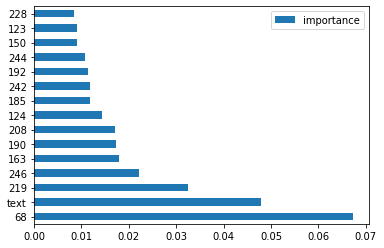

In [113]:
rf_importances = pd.DataFrame(rf.feature_importances_, columns=['importance'], index=feature_cols)
rf_importances.sort_values('importance', ascending=False).iloc[0:15].plot(kind='barh')